### Plot both templates on top of data ###

In [175]:
import numpy as np
import fitsio
# from astropy.io import fits
from astropy.table import Table, join
import desispec.io
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Truth Tables 

In [176]:
truth = Table.read('/global/cfs/cdirs/desi/sv/vi/TruthTables/ARCHIVE/truth_table_QSO_tile68002_night20200315.csv')
truth.rename_column('TargetID', 'TARGETID')
len(truth)

917

In [177]:
#- Use different names to not blow away previous variables
hmfzb = Table.read('/global/cfs/cdirs/desi/users/rdoshi99/desi_qso_templates/data_v5/rrqso/zbest-hmf-68002.fits', 'ZBEST')
len(hmfzb)

5000

In [178]:
rrzb = Table.read('/global/cfs/cdirs/desi/users/rdoshi99/desi_qso_templates/data_v5/rrqso/zbest-hmf-68002-rr.fits', 'ZBEST')
len(rrzb)

5000

In [179]:
compare_hmf = join(truth, hmfzb, keys='TARGETID')
compare_tot = join(compare_hmf, rrzb, keys='TARGETID')
assert(len(compare_tot) == len(truth))

qsos = compare_tot[compare_tot['best spectype']=='QSO']
len(qsos)

361

We are only working with true QSOs.

The colnames with suffix _1 are HMF-empca, and the colnames with a suffix of _2 are the current templates.

In [180]:
print(qsos.colnames)
print()

['TARGETID', 'Redrock z', 'best z', 'best class', 'Redrock spectype', 'best spectype', 'best issue', 'all VI comments', 'merger comment', 'N_VI', 'DELTACHI2_1', 'FIBER', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'CHI2_1', 'COEFF_1', 'Z_1', 'ZERR_1', 'ZWARN_1', 'NPIXELS_1', 'SPECTYPE_1', 'SUBTYPE_1', 'NCOEFF_1', 'DELTACHI2_2', 'NUMEXP_1', 'NUMTILE_1', 'CHI2_2', 'COEFF_2', 'Z_2', 'ZERR_2', 'ZWARN_2', 'NPIXELS_2', 'SPECTYPE_2', 'SUBTYPE_2', 'NCOEFF_2', 'DELTACHI2', 'NUMEXP_2', 'NUMTILE_2']



### Compare the fits via plots ###

In [181]:
tileid = 68002
night = 20200315
indir = f'/global/cfs/cdirs/desi/spectro/redux/andes/tiles/{tileid}/{night}'

In [182]:
def load_templates(filename):
    """returns wave[nwave], eigvec[nwave, nvec]"""
    eigvec, header = fitsio.read(filename, header=True)
    loglam = header['CRVAL1'] + np.arange(header['NAXIS1'])*header['CDELT1']
    wave = 10**loglam
    
    return wave, eigvec.T

In [183]:
#- HMF-empca templates
hmfwave, hmfeigvec = load_templates("/global/cfs/cdirs/desi/users/rdoshi99/desi_qso_templates/data_v5/redrock-templates/rrtemplate-qso.fits")
print('hmfeigvec shape is {}'.format(hmfeigvec.shape))

#- Standard redrock templates
rrwave, rreigvec = load_templates("/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master/rrtemplate-qso.fits")
print('rrfeigvec shape is {}'.format(rreigvec.shape))

hmfeigvec shape is (12586, 6)
rrfeigvec shape is (13637, 4)


In [184]:
from scipy.signal import medfilt
def smoother(arr):
    return medfilt(arr, kernel_size=11)

In [185]:
def plot_spectrum(spectra, i):
    plotopts = dict(alpha=0.7, lw=0.5)
    
    b = smoother(spectra.flux['b'][i])
    r = smoother(spectra.flux['r'][i])
    z = smoother(spectra.flux['z'][i])
    
    plot(spectra.wave['b'], b, '-', color='C0', **plotopts)
    plot(spectra.wave['r'], r, '-', color='C3', **plotopts)
    plot(spectra.wave['z'], z, '-', color='0.3', **plotopts)

### Old templates got correct but new templates wrong

To find patterns in the spectra which the old templates got correct but the new templates did not, we first filter by which objects the old templates classified as QSOs without warnings. Then we only consider those objects for which the redshift prediction is within 0.01 of the truth.

In [186]:
# find spectra the old templates got correct
# i.e. where SPECTYPE_2 IS QSO
# and zwarn is 0
old_qsos = qsos[(qsos['SPECTYPE_2']=='QSO') & (qsos['ZWARN_2']==0)]
print('Old templates classified {}/{} as QSOs correctly'.format(len(old_qsos), len(qsos)))
print(len(old_qsos)/len(qsos)*100)
print()

# find spectra where predicted redshift is accurate
old_correct = old_qsos[abs(old_qsos['Z_2']-old_qsos['best z']) <= 0.01]
print('Of those, it estimated {}/{} redshifts correctly'.format(len(old_correct), len(old_qsos)))
print(len(old_correct)/len(old_qsos)*100)
print()

Old templates classified 279/361 as QSOs correctly
77.28531855955679

Of those, it estimated 272/279 redshifts correctly
97.4910394265233



To get similar metrics for the new templates:

In [187]:
# find spectra the new templates got correct
# i.e. where SPECTYPE_1 IS QSO
# and zwarn is 0
new_qsos = qsos[(qsos['SPECTYPE_1']=='QSO') & (qsos['ZWARN_1']==0)]
print('New templates classified {}/{} as QSOs correctly'.format(len(new_qsos), len(qsos)))
print(len(new_qsos)/len(qsos)*100)
print()

# find spectra where predicted redshift is accurate
new_correct = new_qsos[abs(new_qsos['Z_1']-new_qsos['best z']) <= 0.01]
print('Of those, it estimated {}/{} redshifts correctly'.format(len(new_correct), len(new_qsos)))
print(len(new_correct)/len(new_qsos)*100)
print()


New templates classified 301/361 as QSOs correctly
83.37950138504155

Of those, it estimated 278/301 redshifts correctly
92.35880398671097



### QSOs that the old templates correctly estimated but the new ones got wrong

In [188]:
errors = old_correct[abs(old_correct['Z_1']-old_correct['best z']) > .01]
len(errors)

15

**errors which the new templates did not consider qsos**

In [189]:
non_qso_errors = errors[errors['SPECTYPE_1']!='QSO']
print(len(non_qso_errors))

non_qso_errors[['TARGETID', 'best z', 'SPECTYPE_1', 'ZWARN_1', 'Z_1', 'SPECTYPE_2', 'ZWARN_2', 'Z_2']]

4


TARGETID,best z,SPECTYPE_1,ZWARN_1,Z_1,SPECTYPE_2,ZWARN_2,Z_2
int64,float64,bytes6,int64,float64,bytes6,int64,float64
35185947926597593,0.9751,GALAXY,0,1.6057122399584989,QSO,0,0.975124557232629
35185953916062521,4.0833,GALAXY,4,0.6548656418058517,QSO,0,4.083261108933208
35185971863490145,1.86,GALAXY,4,0.7597626971448375,QSO,0,1.860041515545726
35185971871877775,2.2342,GALAXY,0,0.5646663938305806,QSO,0,2.2342378308467


In [192]:
tids_data=np.array(non_qso_errors['TARGETID']).reshape(len(non_qso_errors),1)
tids = Table(rows=tids_data, names=['tids'])
plot_df = non_qso_errors

- none of these in spec 0, 3, 5, 7-9

In [193]:
spec = 1
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

1


---------------TargetID is 35185947926597593---------------

ZWARN_1: 0

HMF-empca Z: 1.6057122399584989
current template Z: 0.975124557232629
true Z: 0.9751

Velocity diff: 95784.35116578892


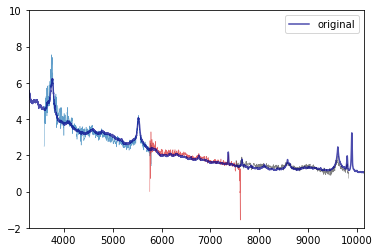

In [196]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
# plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,10);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [105]:
spec = 2
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

1


---------------TargetID is 35185953916062521---------------

ZWARN_1: 4

HMF-empca Z: 0.6548656418058517
current template Z: 4.083261108933208
true Z: 4.0833

Velocity diff: 202335.15776331213


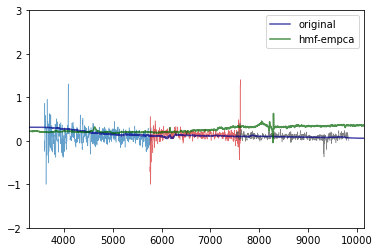

In [106]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2, 3);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [107]:
spec = 4
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

1


---------------TargetID is 35185971863490145---------------

ZWARN_1: 4

HMF-empca Z: 0.7597626971448375
current template Z: 1.860041515545726
true Z: 1.86

Velocity diff: 115409.50729249956


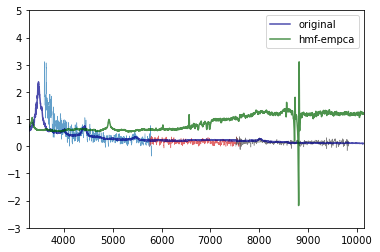

In [108]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-3, 5);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [109]:
spec = 6
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

1


---------------TargetID is 35185971871877775---------------

ZWARN_1: 0

HMF-empca Z: 0.5646663938305806
current template Z: 2.2342378308467
true Z: 2.2342

Velocity diff: 154863.670104145


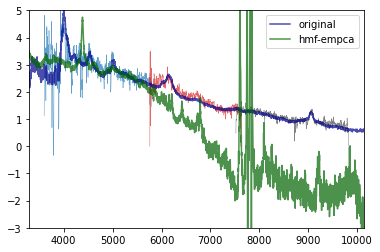

In [110]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-3, 5);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

**errors which the new templates did find qsos but got wrong**

In [111]:
qso_notacc = errors[errors['SPECTYPE_1']=='QSO']
print(len(qso_notacc))

qso_notacc[['TARGETID', 'best z', 'SPECTYPE_1', 'ZWARN_1', 'Z_1', 'SPECTYPE_2', 'ZWARN_2', 'Z_2']]

11


TARGETID,best z,SPECTYPE_1,ZWARN_1,Z_1,SPECTYPE_2,ZWARN_2,Z_2
int64,float64,bytes6,int64,float64,bytes6,int64,float64
35185935947663404,2.479125,QSO,0,2.489562323793855,QSO,0,2.4764731211664888
35185947951761780,2.052,QSO,0,2.071126357317223,QSO,0,2.051966165124749
35185953920254057,2.0272,QSO,0,2.0047297767904775,QSO,0,2.0271931898803373
35185953949616689,1.5443,QSO,4,2.740012772517394,QSO,0,1.5443012226106403
35185959918112239,4.4385,QSO,0,4.4499222149103,QSO,0,4.438453743751121
35185971871879244,2.7147,QSO,0,2.690709266949482,QSO,0,2.7080402183957513
35185971884458211,2.1654,QSO,0,2.1850814863605312,QSO,0,2.1751513104401683
35185977861345246,1.8691,QSO,0,1.857085633557651,QSO,0,1.8690809734020246
35185983792087519,2.9633,QSO,0,2.973985638731535,QSO,0,2.9633365533133786


In [112]:
tids_data=np.array(qso_notacc['TARGETID']).reshape(len(qso_notacc),1)
tids = Table(rows=tids_data, names=['tids'])
plot_df = qso_notacc

- none of these in spec 2, 3, 5
- for the ones in spec 0, 1, 4, 7 redshift is very close

In [113]:
spec = 0
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

1


---------------TargetID is 35185935947663404---------------

ZWARN_1: 0

HMF-empca Z: 2.489562323793855
current template Z: 2.4764731211664888
true Z: 2.479125

Velocity diff: 899.9955845669799


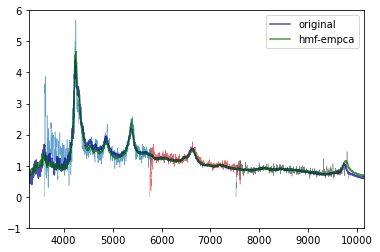

In [118]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-1,6);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [119]:
spec = 1
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

1


---------------TargetID is 35185953920254057---------------

ZWARN_1: 0

HMF-empca Z: 2.0047297767904775
current template Z: 2.0271931898803373
true Z: 2.0272

Velocity diff: 2226.8323740938126


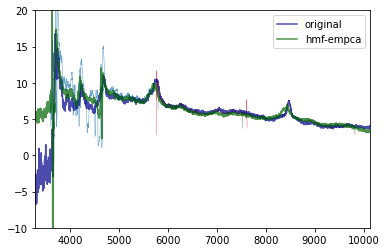

In [120]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-10,20);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [121]:
spec = 4
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

1


---------------TargetID is 35185983792087519---------------

ZWARN_1: 0

HMF-empca Z: 2.973985638731535
current template Z: 2.9633365533133786
true Z: 2.9633

Velocity diff: 808.8440490148569


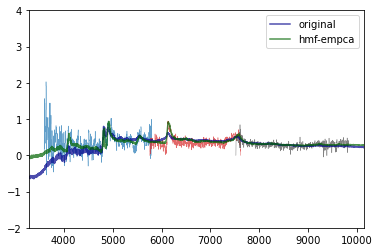

In [122]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,4);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [123]:
spec = 6
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

3


---------------TargetID is 35185971871879244---------------

ZWARN_1: 0

HMF-empca Z: 2.690709266949482
current template Z: 2.7080402183957513
true Z: 2.7147

Velocity diff: 1937.4969486514137


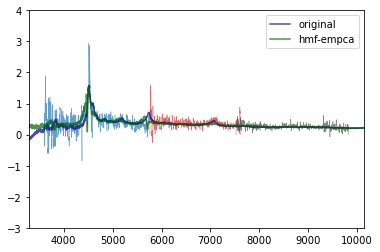

In [124]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-3,4);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

---------------TargetID is 35185983813059888---------------

ZWARN_1: 0

HMF-empca Z: 2.5467024842701207
current template Z: 2.5292389605584304
true Z: 2.53445

Velocity diff: 1039.9765963689345


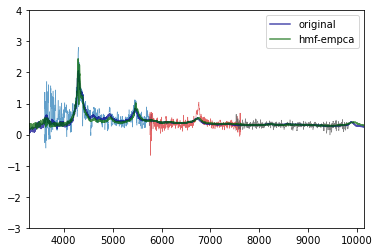

In [126]:
tid = spectra.target_ids()[1]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-3,4);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

---------------TargetID is 35185989781557046---------------

ZWARN_1: 0

HMF-empca Z: 1.7911445468120537
current template Z: 0.6024605670238001
true Z: 0.6025

Velocity diff: 222523.16008962


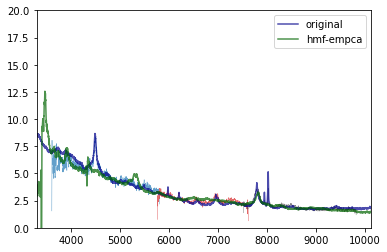

In [127]:
tid = spectra.target_ids()[2]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(0,20);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [128]:
spec = 7
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

3


---------------TargetID is 35185959918112239---------------

ZWARN_1: 0

HMF-empca Z: 4.4499222149103
current template Z: 4.438453743751121
true Z: 4.4385

Velocity diff: 630.0752915491305


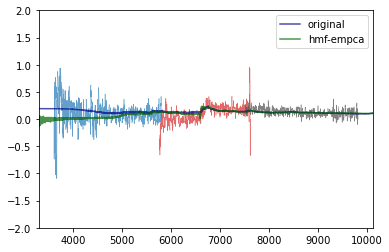

In [129]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,2);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

---------------TargetID is 35185971884458211---------------

ZWARN_1: 0

HMF-empca Z: 2.1850814863605312
current template Z: 2.1751513104401683
true Z: 2.1654

Velocity diff: 1865.3079889301107


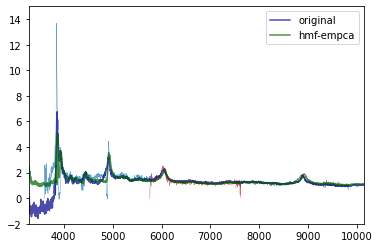

In [131]:
tid = spectra.target_ids()[1]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,15);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

---------------TargetID is 35185977861345246---------------

ZWARN_1: 0

HMF-empca Z: 1.857085633557651
current template Z: 1.8690809734020246
true Z: 1.8691

Velocity diff: 1256.2510657365249


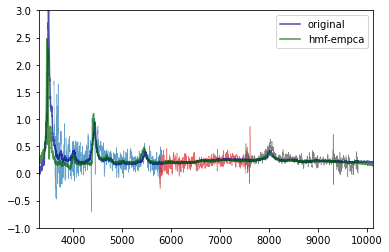

In [132]:
tid = spectra.target_ids()[2]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-1,3);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [133]:
spec = 8
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

2


---------------TargetID is 35185947951761780---------------

ZWARN_1: 0

HMF-empca Z: 2.071126357317223
current template Z: 2.051966165124749
true Z: 2.052

Velocity diff: 1880.0482290848195


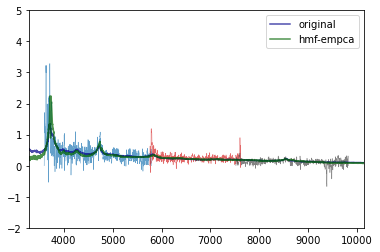

In [134]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,5);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

---------------TargetID is 35185953949616689---------------

ZWARN_1: 4

HMF-empca Z: 2.740012772517394
current template Z: 1.5443012226106403
true Z: 1.5443

Velocity diff: 140987.23883001937


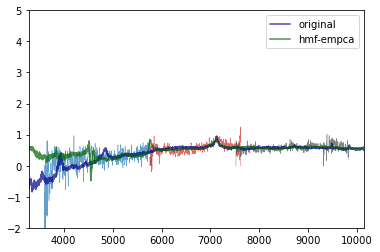

In [135]:
tid = spectra.target_ids()[1]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,5);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

### New QSOs correct, old qsos incorrect

In [139]:
new_better_qsos = qsos[(qsos['SPECTYPE_1']=='QSO') & (qsos['SPECTYPE_2']!='QSO')]
print('New templates classified {}/{} Qsos correctly which the old did not identify'.format(len(new_better_qsos), len(qsos)))
print(len(new_better_qsos)/len(qsos)*100)
print()

acc_redshift = new_better_qsos[abs(new_better_qsos['Z_1']-new_better_qsos['best z']) <= 0.01]
print('Of these identified, {}/{} were accurate in their redshift estimates'.format(len(acc_redshift), len(new_better_qsos)))
print(len(acc_redshift)/len(new_better_qsos)*100)

New templates classified 39/361 Qsos correctly which the old did not identify
10.80332409972299

Of these identified, 29/39 were accurate in their redshift estimates
74.35897435897436


#### Inaccurate ones

In [141]:
inacc_better = new_better_qsos[abs(new_better_qsos['Z_1']-new_better_qsos['best z']) > 0.01]
print(len(inacc_better))

inacc_better[['TARGETID', 'best z', 'SPECTYPE_1', 'ZWARN_1', 'Z_1', 'SPECTYPE_2', 'ZWARN_2', 'Z_2']]

10


TARGETID,best z,SPECTYPE_1,ZWARN_1,Z_1,SPECTYPE_2,ZWARN_2,Z_2
int64,float64,bytes6,int64,float64,bytes6,int64,float64
35185929933034185,2.19,QSO,0,2.2066167856149437,GALAXY,0,0.18958010379732457
35185941937129120,2.7651,QSO,0,2.7871521940254733,GALAXY,0,1.1723378852434325
35185947918205692,1.278,QSO,0,1.145819201722931,GALAXY,0,0.39894894583962126
35185947947565547,1.29,QSO,0,2.3601527914409677,GALAXY,0,0.8921412533577999
35185953899284082,1.2407,QSO,0,1.75178573653169,GALAXY,0,0.18569451110721738
35185971842518798,2.1335,QSO,0,1.7019956197727542,GALAXY,0,0.8908971816514807
35185971863486610,2.3839,QSO,0,1.6929694838451013,GALAXY,4,1.4351567413688693
35185977836179178,2.1267,QSO,0,2.101167253701322,GALAXY,0,0.8088197450567032
35185989773164632,2.42925,QSO,0,0.9198776242334911,GALAXY,0,1.578862741942779


In [142]:
tids_data=np.array(inacc_better['TARGETID']).reshape(len(inacc_better),1)
tids = Table(rows=tids_data, names=['tids'])
plot_df = inacc_better

- none of these in spec 0, 6-9

In [144]:
spec = 1
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

2


---------------TargetID is 35185929933034185---------------

ZWARN_1: 0

HMF-empca Z: 2.2066167856149437
current template Z: 0.18958010379732457
true Z: 2.19

Velocity diff: 1562.7071111232349


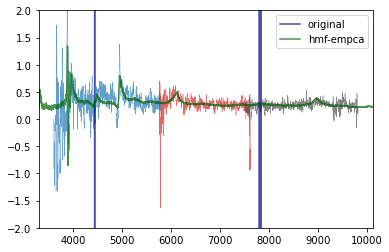

In [147]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,2);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

---------------TargetID is 35185941937129120---------------

ZWARN_1: 0

HMF-empca Z: 2.7871521940254733
current template Z: 1.1723378852434325
true Z: 2.7651

Velocity diff: 1757.1002649709244


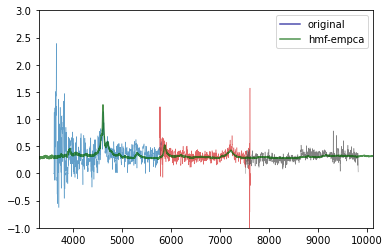

In [150]:
tid = spectra.target_ids()[1]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-1,3);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [151]:
spec = 2
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

2


---------------TargetID is 35185947918205692---------------

ZWARN_1: 0

HMF-empca Z: 1.145819201722931
current template Z: 0.39894894583962126
true Z: 1.278

Velocity diff: 17407.480018929204


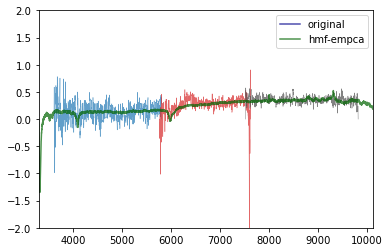

In [153]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,2);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

---------------TargetID is 35185953899284082---------------

ZWARN_1: 0

HMF-empca Z: 1.75178573653169
current template Z: 0.18569451110721738
true Z: 1.2407

Velocity diff: 68427.5989465377


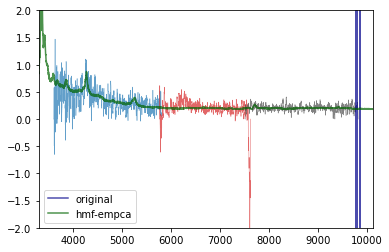

In [155]:
tid = spectra.target_ids()[1]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,2);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [156]:
spec = 3
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

1


---------------TargetID is 35185971842518798---------------

ZWARN_1: 0

HMF-empca Z: 1.7019956197727542
current template Z: 0.8908971816514807
true Z: 2.1335

Velocity diff: 41312.05172113413


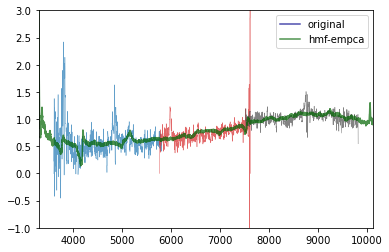

In [159]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-1,3);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [160]:
spec = 4
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

1


---------------TargetID is 35185971863486610---------------

ZWARN_1: 0

HMF-empca Z: 1.6929694838451013
current template Z: 1.4351567413688693
true Z: 2.3839

Velocity diff: 61254.515454496184


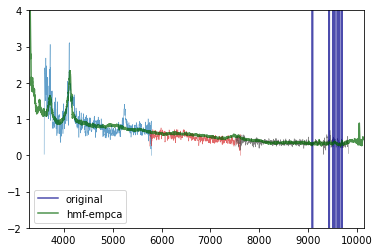

In [162]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,4);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [163]:
spec = 5
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

3


---------------TargetID is 35185977836179178---------------

ZWARN_1: 0

HMF-empca Z: 2.101167253701322
current template Z: 0.8088197450567032
true Z: 2.1267

Velocity diff: 2449.810947517646


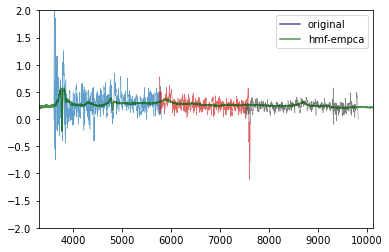

In [165]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,2);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

---------------TargetID is 35185989773164632---------------

ZWARN_1: 0

HMF-empca Z: 0.9198776242334911
current template Z: 1.578862741942779
true Z: 2.42925

Velocity diff: 132043.94918129407


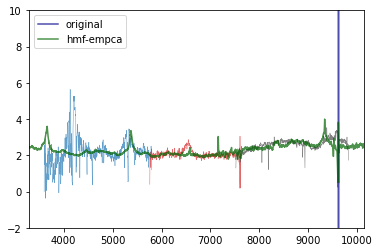

In [167]:
tid = spectra.target_ids()[1]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,10);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

---------------TargetID is 35185995733271326---------------

ZWARN_1: 0

HMF-empca Z: 0.3075988361641117
current template Z: 1.3016430784451265
true Z: 1.3016

Velocity diff: 129562.19549477167


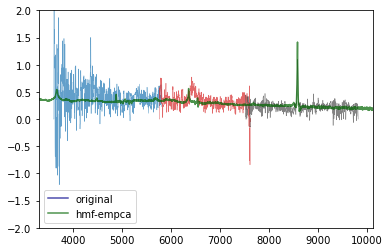

In [168]:
tid = spectra.target_ids()[2]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,2);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))

In [172]:
spec = 9
spectra = desispec.io.read_spectra(f'{indir}/coadd-{spec}-{tileid}-{night}.fits')
zbest = Table.read(f'{indir}/zbest-{spec}-{tileid}-{night}.fits', 'ZBEST')

spectra = spectra.select(targets=tids_data)
print(len(spectra.target_ids()))

1


---------------TargetID is 35185947947565547---------------

ZWARN_1: 0

HMF-empca Z: 2.3601527914409677
current template Z: 0.8921412533577999
true Z: 1.29

Velocity diff: 140194.68883506127


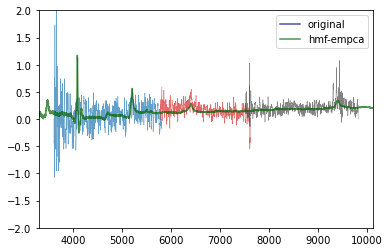

In [174]:
tid = spectra.target_ids()[0]
print("---------------TargetID is {}---------------".format(tid))
print()

i = np.where(plot_df['TARGETID']==tid)[0][0]

num_rreigvec = rreigvec.shape[1]
num_hmfeigvec = hmfeigvec.shape[1]

spec_i = np.where(spectra.fibermap['TARGETID'] == tid)[0][0]
rr_i = np.where(plot_df['TARGETID'] == tid)[0][0]
hmf_i = np.where(plot_df['TARGETID'] == tid)[0][0]

plot_spectrum(spectra, spec_i)
xmin, xmax = xlim()


rr_z = plot_df['Z_2'][rr_i]
hmf_z = plot_df['Z_1'][hmf_i]

rrmodel = rreigvec.dot(plot_df['COEFF_2'][rr_i][0:num_rreigvec])
hmfmodel = hmfeigvec.dot(plot_df['COEFF_1'][hmf_i][0:num_hmfeigvec])

plot(rrwave*(1+rr_z), rrmodel, label='original', alpha=0.7, color='darkblue')
plot(hmfwave*(1+hmf_z), hmfmodel, label='hmf-empca', alpha=0.7, color='darkgreen')

xlim(xmin, xmax);
ylim(-2,2);
legend();

print('ZWARN_1: {}'.format(plot_df['ZWARN_1'][i]))
print()
print('HMF-empca Z: {}'.format(hmf_z))
print('current template Z: {}'.format(rr_z))
true_z = plot_df['best z'][i]
print('true Z: {}'.format(true_z))
print()
c = 3*10**5 # km/s
vel_diff = abs(hmf_z-true_z)/(1+true_z) * c
print('Velocity diff: {}'.format(vel_diff))